# Mapping the intertidal zone

## Load satellite data using odc-stac

In [119]:
import odc.stac
import pystac_client

# Connect to STAC catalog
catalog = pystac_client.Client.open("https://explorer.dea.ga.gov.au/stac")

# Set cloud defaults
odc.stac.configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
)

# Build a query
bbox = [122.12, -18.25, 122.43, -17.93]
query = catalog.search(
    bbox=bbox,
    collections=["ga_ls8c_ard_3", "ga_ls9c_ard_3"],
    datetime="2024-01-01/2024-12-31",
    filter = "eo:cloud_cover < 10"
)

# Search the STAC catalog for all items matching the query
ds = odc.stac.load(
    list(query.items()),
    bands=["nbart_green", "nbart_nir"],
    crs="utm",
    resolution=50,
    groupby="solar_day",
    bbox=bbox,
    fail_on_error=False,
    chunks={},
)

In [120]:
ds[["ndwi"]] = (ds.nbart_green - ds.nbart_nir) / (ds.nbart_green + ds.nbart_nir) 
print(ds)

<xarray.Dataset> Size: 279MB
Dimensions:      (y: 712, x: 680, time: 48)
Coordinates:
  * y            (y) float64 6kB 8.017e+06 8.017e+06 ... 7.982e+06 7.982e+06
  * x            (x) float64 5kB 4.068e+05 4.069e+05 ... 4.407e+05 4.408e+05
    spatial_ref  int32 4B 32751
  * time         (time) datetime64[ns] 384B 2024-01-07T01:55:31.679580 ... 20...
Data variables:
    nbart_green  (time, y, x) float32 93MB dask.array<chunksize=(1, 712, 680), meta=np.ndarray>
    nbart_nir    (time, y, x) float32 93MB dask.array<chunksize=(1, 712, 680), meta=np.ndarray>
    ndwi         (time, y, x) float32 93MB dask.array<chunksize=(1, 712, 680), meta=np.ndarray>


In [121]:
from eo_tides.eo import tag_tides

ds = tag_tides(
    ds=ds,
    model="EOT20",
    directory="../../tests/data/tide_models"
)

Setting tide modelling location from dataset centroid: 122.28, -18.09
Modelling tides using EOT20


In [122]:
lowtide_thresh, hightide_thresh = ds.tide_height.quantile([0.2, 0.8])

In [123]:
ndwi_lowtide = ds.ndwi.sel(time=ds.tide_height < lowtide_thresh)
print(ndwi_lowtide)

<xarray.DataArray 'ndwi' (time: 10, y: 712, x: 680)> Size: 19MB
dask.array<getitem, shape=(10, 712, 680), dtype=float32, chunksize=(1, 712, 680), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 6kB 8.017e+06 8.017e+06 ... 7.982e+06 7.982e+06
  * x            (x) float64 5kB 4.068e+05 4.069e+05 ... 4.407e+05 4.408e+05
    spatial_ref  int32 4B 32751
  * time         (time) datetime64[ns] 80B 2024-02-01T01:49:24.643430 ... 202...
    tide_model   <U5 20B 'EOT20'
    quantile     float64 8B 0.2


In [124]:
ndwi_lowtide_median = ndwi_lowtide.median(dim="time")
print(ndwi_lowtide_median)

<xarray.DataArray 'ndwi' (y: 712, x: 680)> Size: 2MB
dask.array<nanmedian, shape=(712, 680), dtype=float32, chunksize=(712, 680), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 6kB 8.017e+06 8.017e+06 ... 7.982e+06 7.982e+06
  * x            (x) float64 5kB 4.068e+05 4.069e+05 ... 4.407e+05 4.408e+05
    spatial_ref  int32 4B 32751
    tide_model   <U5 20B 'EOT20'
    quantile     float64 8B 0.2


In [125]:
ndwi_lowtide_median.load();

In [126]:
ndwi_lowtide_median.odc.explore(vmin=-1, vmax=1, cmap="RdBu")

In [127]:
ndwi_hightide = ds.ndwi.sel(time=ds.tide_height > hightide_thresh)
ndwi_hightide_median = ndwi_hightide.median(dim="time")
ndwi_hightide_median.load()
ndwi_hightide_median.odc.explore(vmin=-1, vmax=1, cmap="RdBu")

Text(0.5, 1.0, 'High tide')

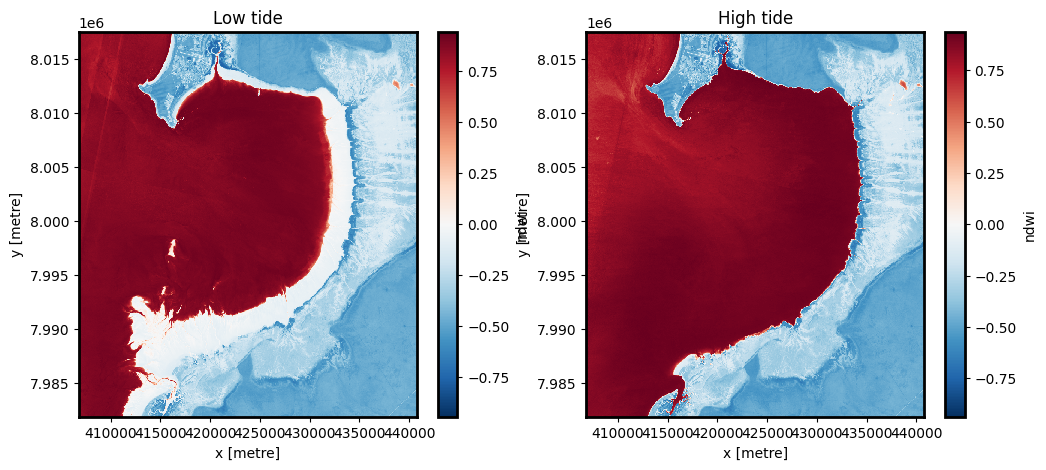

In [128]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ndwi_lowtide_median.plot.imshow(ax=axes[0])
ndwi_hightide_median.plot.imshow(ax=axes[1])
axes[0].set_title("Low tide")
axes[1].set_title("High tide")

In [129]:
intertidal = ~(ndwi_lowtide_median > 0.0) & (ndwi_hightide_median > 0.0)
intertidal.odc.explore()